In [15]:
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.engine import Layer

from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import RepeatVector, Permute

from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow

import numpy as np
import os
import random
import tensorflow as tf

# Get images

In [3]:
X = []
for filename in os.listdir('Train/'):
    X.append(img_to_array(load_img('Train/' + filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0 / 255 * X

print Xtrain.shape

(10, 256, 256, 3)


# Load pretrained weights for inceptionResNetV2

In [4]:
%%time
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

225222656/225209952 [==============================] - 2860s 13us/step
CPU times: user 1min 50s, sys: 1min, total: 2min 50s
Wall time: 48min


# Build model

<img src='images/model.png'>
<img src='images/model_detailed.png' width=800>

In [6]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

# Create inception embedding

In [7]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer (data augmentation)

In [9]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

# Generate training data

In [10]:
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, embed], Y_batch)

# Train model

In [17]:
batch_size = 50
model.compile(optimizer='rmsprop', loss='mse')
model.fit_generator(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1000)

Epoch 1/1
1000/1000 [==============================] - 617s 617ms/step - loss: 0.0064


# Test and output colorizations

In [18]:
color_me = []
for filename in os.listdir('../Full-version/Test/'):
    color_me.append(img_to_array(load_img('../Full-version/Test/' + filename)))
color_me = np.array(color_me, dtype=float)
color_me_raw = color_me
gray_me = gray2rgb(rgb2gray(1.0 / 255 * color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0 / 255 * color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1,))

print color_me.shape
print color_me_embed.shape

(8, 256, 256, 1)
(8, 1000)


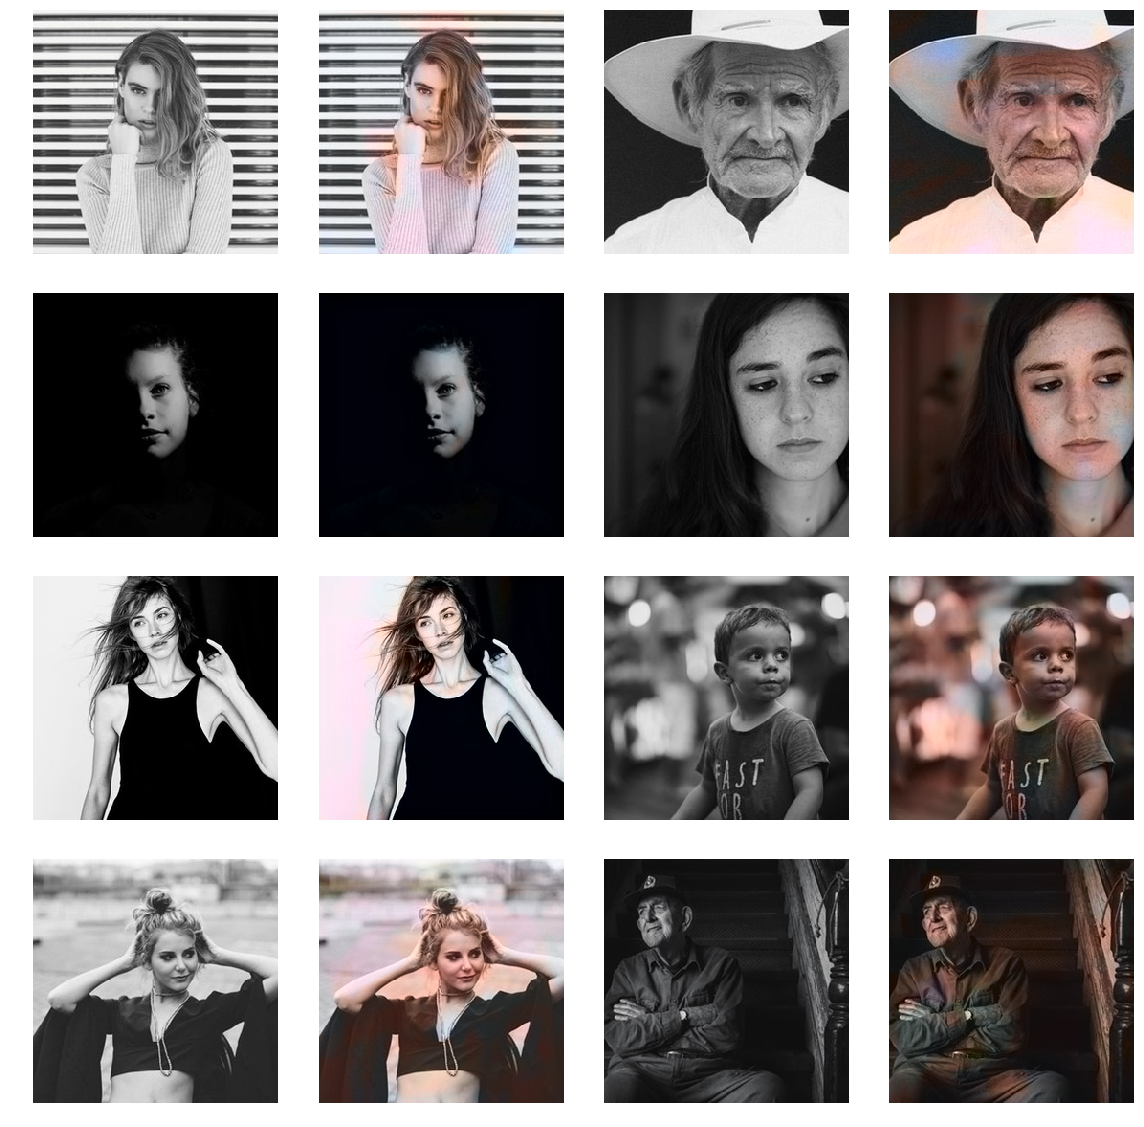

In [19]:
output = model.predict([color_me, color_me_embed])
output = output * 128

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = color_me[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    plt.subplot(4, 4, i*2+1)
    imshow(1.0 / 255 * color_me_raw[i])
    plt.axis('off')
    plt.subplot(4, 4, i*2+2)
    imshow(lab2rgb(cur))
    plt.axis('off')
plt.show()